In [3]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt
import numpy as np

# Lade Ground Truth
gt_file = "filtered_output.json"
coco_gt = COCO(gt_file)

# Lade Detection Results
dt_file = "output/detection_results.json"
coco_dt = coco_gt.loadRes(dt_file)

# Initialisiere COCO Evaluierungstool
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

coco_eval.params.areaRng = [
    [0, 1e10],
    [0, 200**2],     # Small: bis zu 250x250 Pixel
    [200**2, 400**2],   # Medium: zwischen 250x250 und 400x400 Pixel
    [400**2, 1e10]      # Large: größer als 400x400 Pixel
]
coco_eval.params.areaRngLbl = ['all','small', 'medium', 'large']

# Führe Bewertung durch
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# # Annahme: coco_eval wurde bereits ausgeführt
# precision = coco_eval.eval['precision']  # Shape: [T, R, K, A, M]
# iou_thresholds = np.linspace(0.5, 0.95, precision.shape[0])
# recall = np.linspace(0, 1, precision.shape[1])

# # Plot der Precision-Recall-Kurven für verschiedene IoU-Schwellenwerte
# for i, iou in enumerate(iou_thresholds):
#     # Berechnung des Durchschnitts über alle Kategorien (falls nötig)
#     pr_curve = np.mean(precision[i, :, :, 0, :], axis=(1, 2))
#     plt.plot(recall, pr_curve, label=f'IoU={iou:.2f}')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend()
# plt.grid(True)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.show()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.589
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [52]:
import json
import numpy as np

# Load detection results and ground truth annotations
with open(dt_file) as f:
    detection_results = json.load(f)

with open(gt_file) as f:
    gt_annotations = json.load(f)

# Extract the actual annotations
gt_annotations = gt_annotations['annotations'] if 'annotations' in gt_annotations else gt_annotations

# Convert ground truth annotations to a dictionary for quick lookup
gt_dict = {}
for ann in gt_annotations:
    image_id = ann['image_id']
    if image_id not in gt_dict:
        gt_dict[image_id] = []
    gt_dict[image_id].append({
        'category_id': ann['category_id'],
        'bbox': ann['bbox'],
        'matched': False  # Add a flag to track matching
    })

# Define a function to compute Intersection over Union (IoU)
def compute_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area
    return iou

# Parameters
iou_threshold = 0.5

# Initialize counters
true_positives = 0
false_positives = 0
false_negatives = 0

# For each detection, determine if it is a true positive or false positive
for det in detection_results:
    image_id = det['image_id']
    category_id = det['category_id']
    det_bbox = det['bbox']
    
    matched = False
    if image_id in gt_dict:
        for gt in gt_dict[image_id]:
            gt_bbox = gt['bbox']
            gt_category_id = gt['category_id']
            
            if category_id == gt_category_id and not gt['matched']:
                iou = compute_iou(det_bbox, gt_bbox)
                if iou >= iou_threshold:
                    true_positives += 1
                    gt['matched'] = True  # Mark this ground truth as matched
                    matched = True
                    break
    
    if not matched:
        false_positives += 1

# For each ground truth annotation, determine if it is a false negative
for image_id, annotations in gt_dict.items():
    for gt in annotations:
        if not gt['matched']:
            false_negatives += 1

# True negatives are not applicable in this context
true_negatives = "Not applicable"

# Calculate total number of objects based on ground truth
total_objects = len(gt_annotations)

# Print results
print(f'Number of true positives: {true_positives}')
print(f'Number of false positives: {false_positives}')
print(f'Number of false negatives: {false_negatives}')
print(f'Number of true negatives: {true_negatives}')
print(f'Total number of objects (ground truth): {total_objects}')

# Consistency check
assert true_positives + false_negatives == total_objects, "TP + FN should equal the total number of objects"

Number of true positives: 43
Number of false positives: 25
Number of false negatives: 18
Number of true negatives: Not applicable
Total number of objects (ground truth): 61


In [47]:
# Gegebene Werte
true_positives = 190
false_positives = 49
false_negatives = 63
total_objects = 253

# Berechnungen
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)
fdr = false_positives / (true_positives + false_positives)

# Ergebnisse ausgeben
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1_score:.3f}')
print(f'False Discovery Rate (FDR): {fdr:.3f}')


Precision: 0.795
Recall: 0.751
F1-Score: 0.772
False Discovery Rate (FDR): 0.205


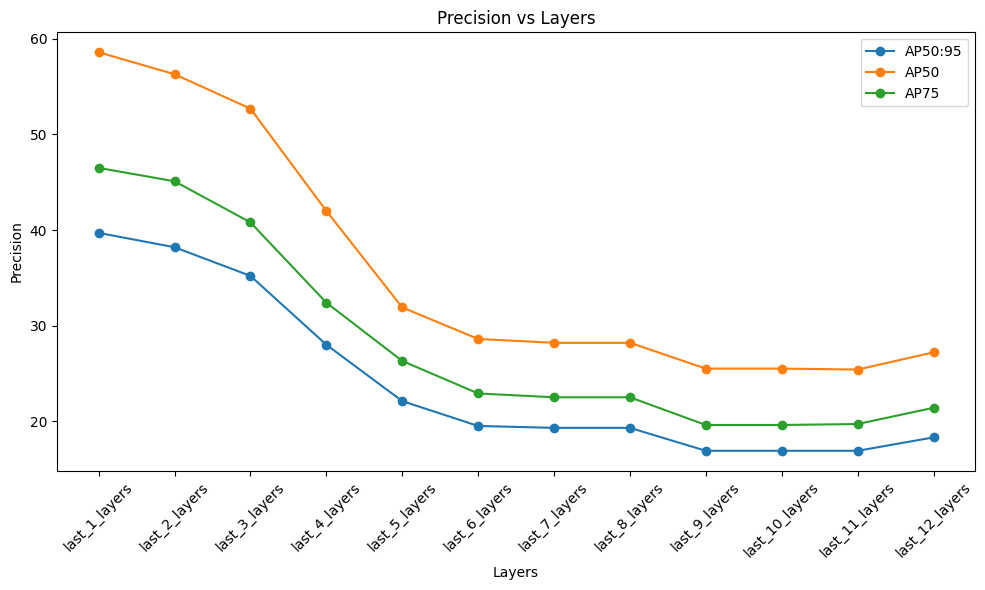

In [15]:
import matplotlib.pyplot as plt

# Data
layers = [
    'last_1_layers', 'last_2_layers', 'last_3_layers', 'last_4_layers', 
    'last_5_layers', 'last_6_layers', 'last_7_layers', 'last_8_layers', 
    'last_9_layers', 'last_10_layers', 'last_11_layers', 'last_12_layers'
]
AP50_95 = [39.7, 38.2, 35.2, 28.0, 22.1, 19.5, 19.3, 19.3, 16.9, 16.9, 16.9, 18.3]
AP50 = [58.6, 56.3, 52.7, 42.0, 31.9, 28.6, 28.2, 28.2, 25.5, 25.5, 25.4, 27.2]
AP75 = [46.5, 45.1, 40.8, 32.4, 26.3, 22.9, 22.5, 22.5, 19.6, 19.6, 19.7, 21.4]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(layers, AP50_95, marker='o', label='AP50:95')
plt.plot(layers, AP50, marker='o', label='AP50')
plt.plot(layers, AP75, marker='o', label='AP75')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('Precision')
plt.title('Precision vs Layers')
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Display plot
plt.show()


In [4]:
import torch
torch.load("ycb_prototypes.pth")

{'prototypes': tensor([[-0.0052,  0.0178, -0.0082,  ..., -0.0049,  0.0888, -0.0531],
         [-0.0074,  0.0150, -0.0089,  ...,  0.0032,  0.0824, -0.0496],
         [ 0.0002, -0.0040, -0.0103,  ..., -0.0022,  0.0375, -0.0341]]),
 'label_names': ['kaneyo_kitchen_bleach',
  'daiso_mod_remover',
  'hellmanns_mayonnaise']}

In [13]:
import torch

# Load the data from the .pth file
x = torch.load("ycb_prototypes.pth")

# Define the initial labels we want to keep
labels_to_keep = ['kaneyo_kitchen_bleach', 'hellmanns_mayonnaise']

# Define the additional label you want to add
additional_label = "daiso_mod_remover"

# Add the additional label to the list of labels to keep
labels_to_keep.append(additional_label.strip())

# Get the indices of the labels we want to keep
indices_to_keep = [x['label_names'].index(label) for label in labels_to_keep if label in x['label_names']]

# Filter the prototypes tensor to keep only the relevant rows
filtered_prototypes = x['prototypes'][indices_to_keep]

# Create a new dictionary with filtered prototypes and labels
filtered_data = {
    'prototypes': filtered_prototypes,
    'label_names': [x['label_names'][i] for i in indices_to_keep]
}

print(filtered_data)

filtered_data['label_names']


{'prototypes': tensor([[-0.0052,  0.0178, -0.0082,  ..., -0.0049,  0.0888, -0.0531],
        [ 0.0002, -0.0040, -0.0103,  ..., -0.0022,  0.0375, -0.0341],
        [-0.0074,  0.0150, -0.0089,  ...,  0.0032,  0.0824, -0.0496]]), 'label_names': ['kaneyo_kitchen_bleach', 'hellmanns_mayonnaise', 'daiso_mod_remover']}


['kaneyo_kitchen_bleach', 'hellmanns_mayonnaise', 'daiso_mod_remover']